In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
# !pip install geomloss
from geomloss import SamplesLoss
import pandas as pd
import numpy as np
from typing import List, Tuple, Sequence

[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [21]:
ref_data = pd.read_csv('data/ref_2_bunnies.csv', sep=',', decimal='.').to_numpy()
source = pd.read_csv('data/source_2_bunnies_def_from_center.csv', sep=',', decimal='.').to_numpy()
ref_data = torch.tensor(ref_data, dtype=torch.float32)
source = torch.tensor(source, dtype=torch.float32)

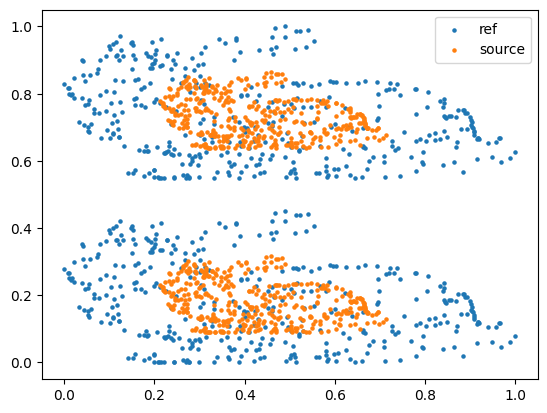

In [24]:
plt.scatter(*ref_data.T, s=5, label='ref')
plt.scatter(*source.T, s=5, label='source')
plt.legend()

In [25]:
def jaccobian_finite_diff(G: nn.Module,
                          z: torch.Tensor,
                          epsilon: float,
                          G_z: torch.Tensor = None,
                          ret_iso_jac_and_I: bool = True):
    """
    :param G: function/network to compute the jaccobian Penalty for.
    :param z: input to G that the Hessian Penalty is taken w.r.t.
    :param epsilon: step size for finite difference.
    :param G_z: precomputed original input.
    :param ret_iso_jac_and_I: if `True`, computes batch J^T @ j and returns it alongside identity I with appropriate shape,
     else returns batch Jacobian.
    :return:
    """

    batch_size, d = z.shape
    if G_z is None:
        G_z = G(z)
    # Gz_rep is [batch_size * d, d]
    Gz_rep = G_z.view(-1, 1, d).repeat(1, d, 1).view(-1, d)
    I = torch.eye(d, device=z.device).repeat(batch_size, 1, 1)
    surg = (epsilon * I + z.unsqueeze(-1)).transpose(2, 1).reshape(-1, d)
    out = G(surg)
    jac = ((out - Gz_rep) / epsilon).reshape(-1, d, d)
    if ret_iso_jac_and_I:
        return torch.bmm(jac, jac), I
    else:
        return jac

In [5]:
class WarpKnn(nn.Module):
    def __init__(self,
                 input_dim=2,
                 hidden_dim=20,
                 w_init_delta=0.02,
                 out_dim=None,
                 alpha=0.05,
                 init_last_layer=False,
                 max_batch_at_once=2500,
                 device='cpu'):
        """
          :param input_dim:
          :param hidden_dim:
          :param w_init_delta:
          :param out_dim:
          :param alpha:
          :param init_last_layer:
          :param max_batch_at_once:
          :param device:
        """

        super(WarpKnn, self).__init__()
        self.w_init_delta = w_init_delta
        self.alpha = alpha
        self.input_dim = input_dim
        self.out_dim = out_dim if out_dim is not None else input_dim
        self.init_last_layer = init_last_layer
        self.max_batch_at_once = max_batch_at_once
        self.block = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.LeakyReLU(self.alpha),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(self.alpha),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(self.alpha),
            nn.Linear(hidden_dim, self.out_dim),
        ).to(device)
        parameters = list(self.block.parameters())
        for j, p in enumerate(parameters[-2:]):
            print(p.data.shape)
            if not self.init_last_layer:
                p.data = self.w_init_delta * torch.rand_like(p.data, requires_grad=True)
            else:
                p.data = self.w_init_delta * torch.rand_like(p.data, requires_grad=True)

    def forward(self, x, large=True):
        if large and x.shape[0] > self.max_batch_at_once:
            return self._calc_large_batch(x)
        else:
            t = self.block(x)
            if self.out_dim == self.input_dim:
                r = t + x
            else:
                raise ValueError(
                    f'Mismatched output and input dimensions:'
                    f' out_dim{self.out_dim} != input_dim{self.input_dim}'
                )
            #     r = t + torch.pca_lowrank(x, self.out_dim)[0]
            return r, t

    def _calc_large_batch(self, x):
        """
        :param x:
        :return:
        """
        data_size = x.shape[0]
        outs = []
        ts = []
        for start in range(0, data_size, self.max_batch_at_once):
            end = start + self.max_batch_at_once
            batch = x[start:end]
            out, t = self(batch)
            outs += [out]
            ts += [t]
        r = torch.concat(outs, 0)
        t = torch.concat(ts, 0)
        return r, t

In [190]:
device = 'cuda'
lr = 1e-2
batch_size = source.shape[0]  #full batch
iterations = 600
hidden = 50
sigma = 0.04
eps = 0.02
lam = 1e-2

# shuffling data to make sure correspondence is lost.
idx = torch.randperm(source.shape[0])
source_data = source[idx]

exp_dict = {}
use_sinkhorn_loss = True
use_jac_penality = False

loss_align_hist = []
loss_reg_hist = []

warpknn_model = WarpKnn(input_dim=ref_data.shape[-1],
                        hidden_dim=hidden,
                        w_init_delta=0.014,
                        alpha=0.05,
                        init_last_layer=True
                        ).to(device)

optim = torch.optim.Adam(list(warpknn_model.parameters()), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',
                                                       factor=0.7,
                                                       patience=50,
                                                       threshold=1e-4,
                                                       min_lr=5e-5,
                                                       threshold_mode='rel')
if use_sinkhorn_loss:
    alignment_loss_fn = SamplesLoss(loss='sinkhorn',
                                    blur=sigma,
                                    p=2,
                                    )
else:
    alignment_loss_fn = SamplesLoss(loss='gaussian', blur=sigma)

# using full batch for this example
batch_X, batch_Y = ref_data, source_data
batch_X = batch_X.to('cuda')
batch_Y = batch_Y.to('cuda')
for idx in range(iterations):
    # batch_X, batch_Y = subsample(ref_data, batch_size)[0], \
    #                subsample(target_data, batch_size)[0]

    out, t = warpknn_model(batch_Y, large=False)
    alignment_loss = alignment_loss_fn(out, batch_X)
    if alignment_loss < 1e-6:
        break
    if use_jac_penality:
        jac_T_jac, I = jaccobian_finite_diff(warpknn_model.block,
                                             batch_Y,
                                             G_z=t,
                                             epsilon=eps,
                                             ret_iso_jac_and_I=True)
        reg_loss = lam * torch.abs(jac_T_jac - I).mean([1, 2]).mean()
        loss = alignment_loss + reg_loss
    else:
        reg_loss = torch.tensor(0.0)
        loss = alignment_loss
    optim.zero_grad()
    loss.backward(retain_graph=True)
    optim.step()
    scheduler.step(alignment_loss)
    every = 5 if idx < 100 else 100
    if idx % every == 0:
        loss_align_hist += [alignment_loss.detach().item()]
        loss_reg_hist += [reg_loss.detach().item()]
        print(f'{idx} || alignment_loss: {alignment_loss:3f}  || reg:{reg_loss :3f}')


torch.Size([2, 50])
torch.Size([2])
0 || alignment_loss: 0.010657  || reg:0.000000
5 || alignment_loss: 0.008822  || reg:0.000000
10 || alignment_loss: 0.004627  || reg:0.000000
15 || alignment_loss: 0.002677  || reg:0.000000
20 || alignment_loss: 0.001646  || reg:0.000000
25 || alignment_loss: 0.002063  || reg:0.000000
30 || alignment_loss: 0.001753  || reg:0.000000
35 || alignment_loss: 0.001647  || reg:0.000000
40 || alignment_loss: 0.001653  || reg:0.000000
45 || alignment_loss: 0.001588  || reg:0.000000
50 || alignment_loss: 0.001572  || reg:0.000000
55 || alignment_loss: 0.001553  || reg:0.000000
60 || alignment_loss: 0.001466  || reg:0.000000
65 || alignment_loss: 0.001371  || reg:0.000000
70 || alignment_loss: 0.001206  || reg:0.000000
75 || alignment_loss: 0.001953  || reg:0.000000
80 || alignment_loss: 0.001005  || reg:0.000000
85 || alignment_loss: 0.000805  || reg:0.000000
90 || alignment_loss: 0.000734  || reg:0.000000
95 || alignment_loss: 0.000570  || reg:0.000000
100 ||

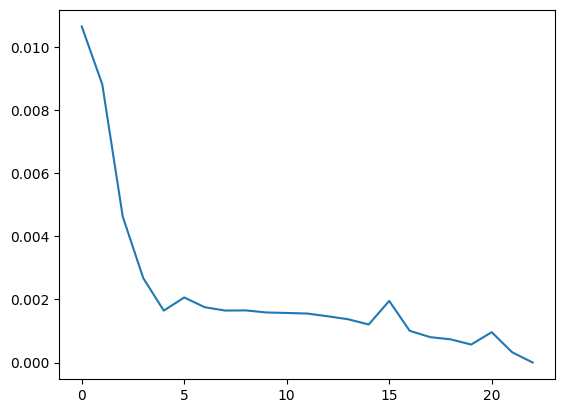

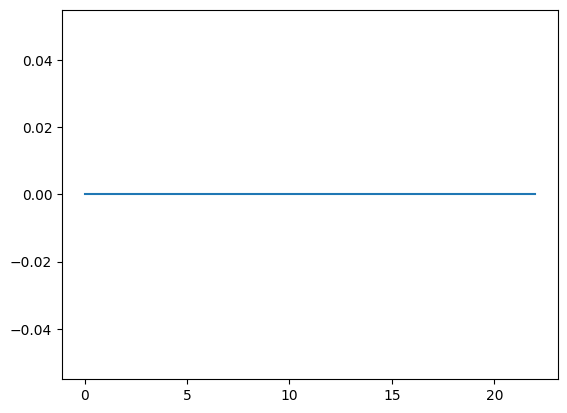

In [191]:
plt.plot(loss_align_hist)
plt.figure()
plt.plot(loss_reg_hist)

(20, 20)
(400, 2)


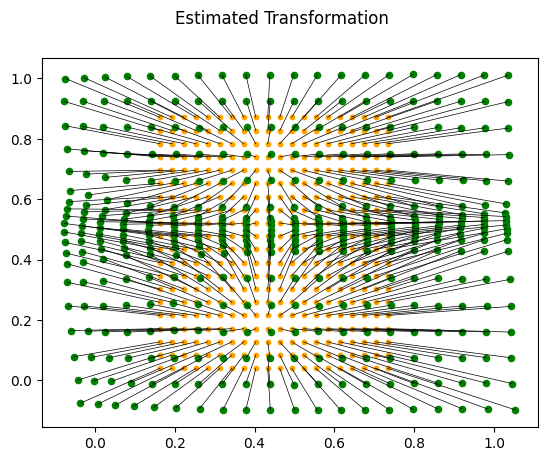

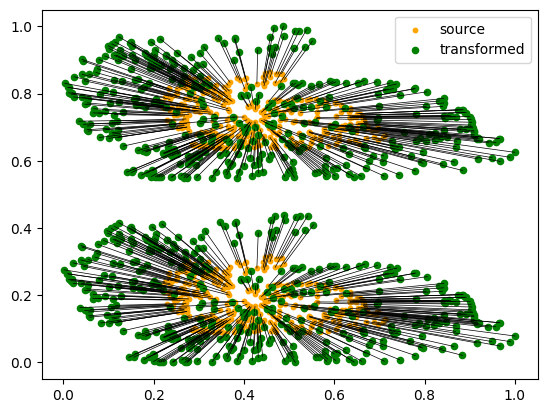

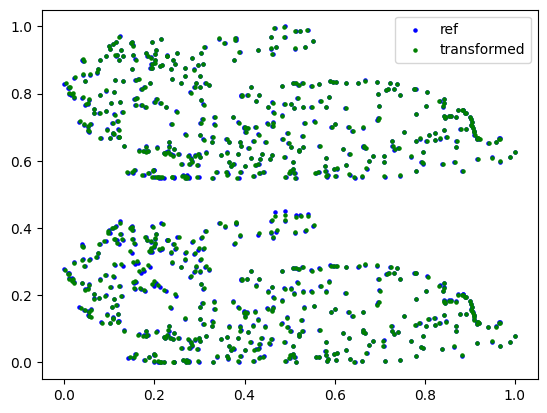

In [192]:
from helper import ndmeshgrid, plot_grid_warp
warpknn_model.train(False)
warpknn_model.to('cpu')
ref_data = ref_data.to('cpu')
source_data = source_data.to('cpu')
plt.figure()
grid_xy_min = source_data.min(0)[0].detach().numpy()-.05
grid_xy_max = source_data.max(0)[0].detach().numpy()+.05
mesh_test = ndmeshgrid(dim=source_data.shape[-1],
                       step=20,
                       mi=grid_xy_min,
                       mx=grid_xy_max,
                       )
print(mesh_test.shape)
Y_trans_mesh = warpknn_model(torch.as_tensor(mesh_test, dtype=torch.float, ))[0].detach().cpu().numpy()
plot_grid_warp(mesh_test, Y_trans_mesh, linewidth=.5, c1='orange', c2='green')
plt.suptitle(f'Estimated Transformation')
Y_trans = warpknn_model(source_data)[0].detach().cpu().numpy()
plt.figure()
plot_grid_warp(source_data, Y_trans, linewidth=.5, c1='orange', c2='green',
               label1='source', label2='transformed')
plt.legend()
plt.figure()
plt.scatter(ref_data[:, 0], ref_data[:, 1], s=5, c='blue', label='ref')
plt.scatter(Y_trans[:, 0], Y_trans[:, 1], s=5, c='green', label='transformed')
plt.legend()

In [193]:
reg_iden = 'jac' if use_jac_penality else 'no_reg'
np.savetxt(f'results/bunny/mesh_input.csv', mesh_test, delimiter=',')
np.savetxt(f'results/bunny/mesh_transformed_{reg_iden}.csv', Y_trans_mesh, delimiter=',')
np.savetxt(f'results/bunny/transformed_source_{reg_iden}.csv', Y_trans, delimiter=',')